**MACHINE LEARNING**

**HRV for detecting arousal**

In [2]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut, KFold, GridSearchCV
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression


In [3]:
# Loading the dataset
file = r"C:\Users\Salin\OneDrive\Documentos\ESSEX\DSPROJECT\PPG_HR_Analysis_Longer_Intervals\Grey_Cal\norm_Grey_Cal_Start_arousal.csv"
df = pd.read_csv(file)

# Displaying info
df.head()
len(df)

1634

In [4]:
X = df.drop(columns=['Participant', 'Stimulus', 'Arousal'])
y = df['Arousal']
groups = df['Participant']

In [ ]:
def evaluate_regression(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)

    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R² Score: {r2:.3f}")
    return

**XGBOOST REGRESSOR**

In [6]:
logo = LeaveOneGroupOut()

In [7]:
true_values = []
predicted_values = []

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

print("LOPO without hyperparameter tuning:")
evaluate_regression(true_values, predicted_values)


LOPO without hyperparameter tuning:
RMSE: 0.285
MAE: 0.233
R² Score: -0.006


In [8]:
global_corr = X.corrwith(y)
global_corr = global_corr.sort_values(key=abs, ascending=False)
global_corr.head(10)

F1_CrossingPoints   -0.199111
NN50                -0.153291
F3_MaxArea          -0.146636
F9_KurtX            -0.079978
F4_MeanArea          0.057464
F2_MinArea           0.051227
F10_KurtY            0.037820
F6_StdY              0.037238
F8_SkewY             0.036542
pNN50               -0.033472
dtype: float64

In [9]:
# Checking number of missing values per column
missing_counts = X.isna().sum()

# Displaying only columns that have missing values
missing_counts[missing_counts > 0].sort_values(ascending=False)

NN50               342
pNN50              342
Parasympathetic     19
F2_MinArea          19
F3_MaxArea          19
F4_MeanArea         19
F5_StdX             19
F6_StdY             19
F7_SkewX            19
F8_SkewY            19
F9_KurtX            19
F10_KurtY           19
dtype: int64

In [10]:
X_mi = X.copy()

# Filling NaNs with column means 
X_mi = X_mi.fillna(X_mi.mean())

<Axes: title={'center': 'Mutual Information Scores'}>

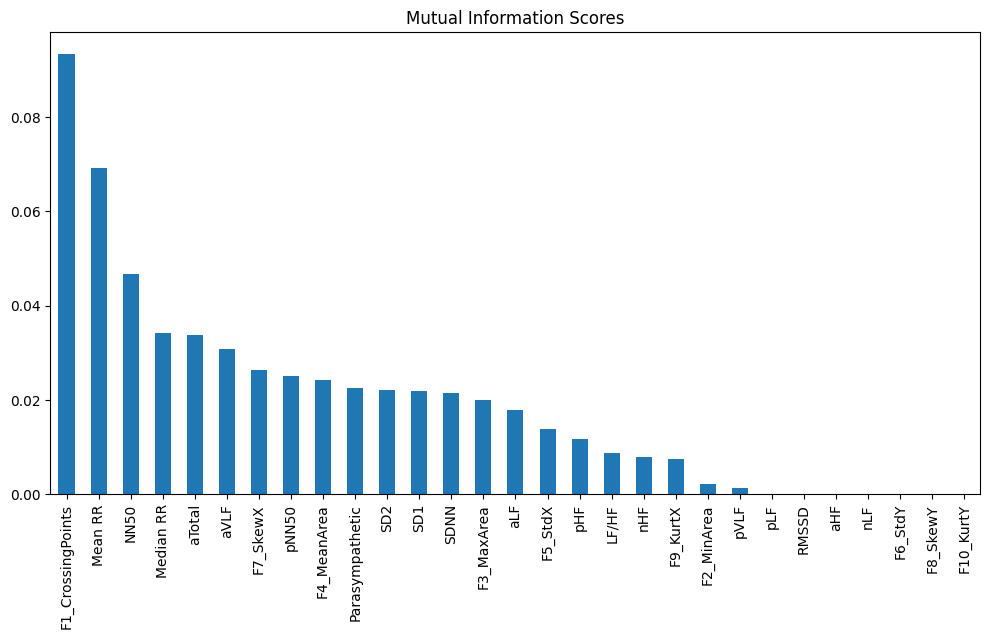

In [11]:
# MI between each feature and arousal
mi_scores = mutual_info_regression(X_mi, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns)
mi_series.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title='Mutual Information Scores')

In [12]:
mi_series.sort_values(ascending=False).head(20)

F1_CrossingPoints    0.093316
Mean RR              0.069139
NN50                 0.046737
Median RR            0.034122
aTotal               0.033793
aVLF                 0.030816
F7_SkewX             0.026298
pNN50                0.025054
F4_MeanArea          0.024174
Parasympathetic      0.022454
SD2                  0.022165
SD1                  0.021987
SDNN                 0.021449
F3_MaxArea           0.019931
aLF                  0.017808
F5_StdX              0.013913
pHF                  0.011796
LF/HF                0.008756
nHF                  0.007966
F9_KurtX             0.007534
dtype: float64

In [13]:
selected_features = selected_features = mi_series[mi_series > 0.02].index.tolist()
X = df[selected_features]
X.head()

,Mean RR,Median RR,SDNN,NN50,pNN50,aVLF,aTotal,SD1,SD2,Parasympathetic,F1_CrossingPoints,F4_MeanArea,F7_SkewX
0,0.039210,0.093410,3.228654,0.166667,1.336744,3.825702,3.802966,3.227238,3.230447,-0.000759,-0.84,0.925245,-2.965765
1,0.166076,0.195852,0.243717,-0.833333,-0.631082,0.411365,0.425074,0.243751,0.244435,-0.000550,-0.46,0.597721,-2.237194
2,0.147075,0.133413,0.512842,-1.000000,-1.000000,1.460010,1.469281,0.510574,0.514109,-0.002335,-0.78,0.740808,-1.942930
3,-0.048725,0.036448,2.725267,-0.500000,-0.280134,1.228109,1.074446,2.725255,2.726687,-0.000384,-0.70,0.856847,1.669547
4,0.040518,0.068274,0.045487,-0.666667,-0.332359,0.726585,0.753965,0.045547,0.046034,-0.000466,-0.36,0.610427,-0.997235


In [14]:
filtered_df = df.dropna(subset=selected_features + ['Arousal'])  # Keeping only valid raws
print(f"Total raws after deleting the Nans:", len(filtered_df))

Total raws after deleting the Nans: 1273


In [15]:
X = filtered_df[selected_features]
y = filtered_df['Arousal']
groups = filtered_df['Participant']

In [16]:
true_values = []
predicted_values = []

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

print("LOPO without hyperparameter tuning with most significant features:")
evaluate_regression(true_values, predicted_values)

LOPO without hyperparameter tuning with most significant features:
RMSE: 0.284
MAE: 0.230
R² Score: 0.051


In [17]:
true_values = []
predicted_values = []
results = [] 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    test_participant = groups.iloc[test_idx].unique()[0]

    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(XGBRegressor(random_state=42), param_grid,
                        cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

    rmse = root_mean_squared_error(y_test, y_pred)

    # Saving Parameters 
    results.append({
        'Participant': test_participant,
        'RMSE': rmse,
        **grid.best_params_
    })

print("Nested LOPO with hyperparameter tuning:")
evaluate_regression(true_values, predicted_values)

# For further use if necessary to check the best parameters
results_df = pd.DataFrame(results)
params_df = results_df.drop(columns=['Participant', 'RMSE'])

Nested LOPO with hyperparameter tuning:
RMSE: 0.270
MAE: 0.232
R² Score: 0.146


Best Parameters per Participant

To understand whether certain model configurations generalize better, the best hyperparameters selected during each LOPO iteration were tracked.

Below:
- The most commonly selected configuration.
- The configuration that resulted in the lowest average RMSE across participants.


In [18]:
# The most used configuration
most_common_configs = (
    params_df.value_counts()
    .reset_index(name='Count')
    .sort_values(by='Count', ascending=False)
    .head(3)
)
print("Most Common Configurations:")
display(most_common_configs)

# The best config for better results
best_avg_configs = (
    results_df
    .groupby(['n_estimators', 'max_depth', 'learning_rate', 'subsample'])['RMSE']
    .mean()
    .reset_index()
    .sort_values(by='RMSE')
    .head(3)
)
print("Best Performing Configurations (Lowest Avg. RMSE):")
display(best_avg_configs)


Most Common Configurations:


,learning_rate,max_depth,n_estimators,subsample,Count
0,0.01,5,200,0.8,33
1,0.01,3,200,0.8,1


Best Performing Configurations (Lowest Avg. RMSE):


,n_estimators,max_depth,learning_rate,subsample,RMSE
0,200,3,0.01,0.8,0.227574
1,200,5,0.01,0.8,0.265074


**Random Forest Regressor**

In [19]:
true_values = []
predicted_values = []

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

evaluate_regression(true_values, predicted_values)
    

RMSE: 0.272
MAE: 0.228
R² Score: 0.133


In [20]:
true_values = []
predicted_values = []
best_params_list = []

# Hyperparameters tunning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    grid = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        cv=inner_cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)
    best_params_list.append(grid.best_params_)

evaluate_regression(true_values, predicted_values)

RMSE: 0.271
MAE: 0.228
R² Score: 0.137


In [21]:
best_params_df = pd.DataFrame(best_params_list)
print("\nBest hyperparameters per participant:")
display(best_params_df.value_counts().head())


Best hyperparameters per participant:


max_depth  min_samples_leaf  min_samples_split  n_estimators
10         2                 5                  200             8
                             2                  200             6
           1                 5                  200             5
                                                100             4
                             2                  200             4
Name: count, dtype: int64